In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
LOCAL = False

if LOCAL:
    df = pd.read_csv('Final_df.csv')
    
else:
    df = pd.read_csv("/content/gdrive/My Drive/capstone project/modified datasets/Final_df.csv")


In [ ]:
df

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,Tweet_volume,Avg_score,Avg_score_norm,Tweet_volume_norm
0,0,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402,1694.0,0.000025,0.043308,0.022462
1,1,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653,3278.0,0.000021,0.032583,0.044547
2,2,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143,3030.0,0.000009,0.000000,0.041089
3,3,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687,5647.0,0.000055,0.129953,0.077577
4,4,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886,4350.0,0.000057,0.136786,0.059494
...,...,...,...,...,...,...,...,...,...,...,...,...
431,431,2022-04-12,39533.714844,40617.585938,39388.328125,40127.183594,40127.183594,30991500854,NaN,NaN,NaN,NaN
432,432,2022-04-13,40123.570312,41430.054688,39712.746094,41166.730469,41166.730469,27691105228,18397.0,0.000058,0.137809,0.255347
433,433,2022-04-14,41160.218750,41451.480469,39695.746094,39935.515625,39935.515625,24342001973,27676.0,0.000063,0.153244,0.384722
434,434,2022-04-15,39939.402344,40617.722656,39866.832031,40553.464844,40553.464844,21756855753,40576.0,0.000075,0.185499,0.564583


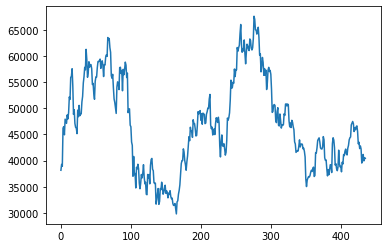

In [ ]:
df['Close'].plot()

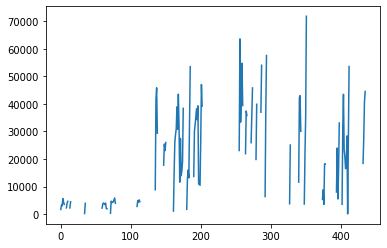

In [ ]:
df['Tweet_volume'].plot()

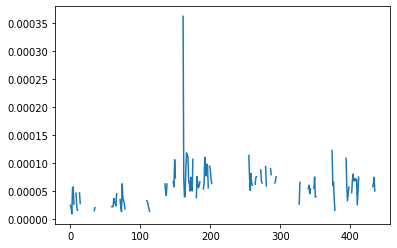

In [ ]:
df['Avg_score'].plot()

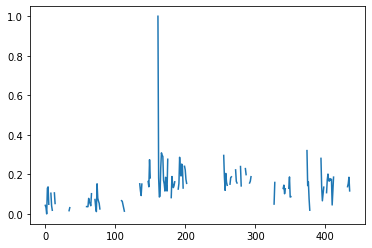

In [ ]:
df['Avg_score_norm'].plot()

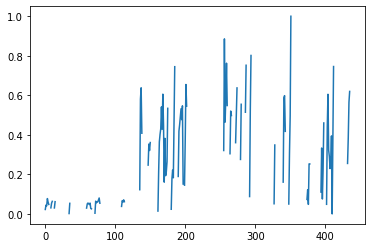

In [ ]:
df['Tweet_volume_norm'].plot()

In [ ]:
df.index=pd.to_datetime(df['Date'],format='%Y-%m-%d')

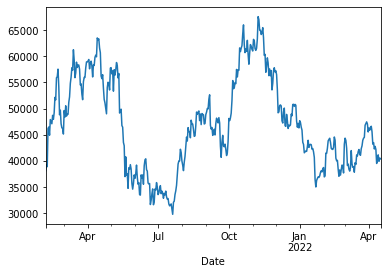

In [ ]:
df['Close'].plot()

In [ ]:
# interpolate missing values 

df.interpolate(method='time', inplace=True)

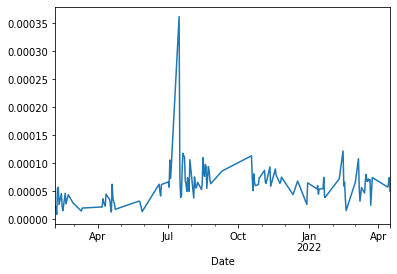

In [ ]:
df['Avg_score'].plot()

In [ ]:
train_df = df[:int(.7*len(df))]
test_df = df[int(.7*len(df)):]

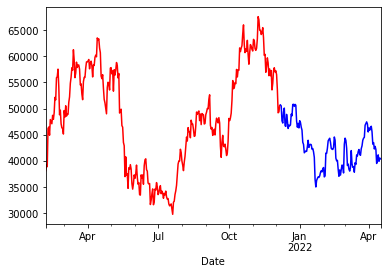

In [ ]:
train_df['Close'].plot(color='red')
test_df['Close'].plot(color='blue')

In [ ]:
#features & target for the model

features = ['Open', 'High', 'Low', 'Volume', 'Tweet_volume', 'Avg_score_norm']
target = ['Close']

In [ ]:
#features & target for the model
featureScaler = StandardScaler()
targetScaler = StandardScaler()

featureScaler.fit(train_df[features])
targetScaler.fit(train_df[target])

StandardScaler()

In [ ]:
featureScaler.mean_

array([4.87576764e+04, 5.01165990e+04, 4.72002390e+04, 4.62037701e+10,
       1.71516880e+04, 1.49834468e-01])

In [ ]:
def create_dataset(train, test):
    
    trainX = featureScaler.transform(train[features])
    trainY = targetScaler.transform(train[target])
    
    testX = featureScaler.transform(test[features])
    testY = targetScaler.transform(test[target])
    
    X_train = np.array(trainX)
    Y_train = np.array(trainY)
    
    X_test = np.array(testX)
    Y_test = np.array(testY)

    return (trainX, trainY), (testX,testY)    

In [ ]:
WINDOW_SIZE = 10

(X_train, Y_train), (X_test, Y_test) = create_dataset(train_df, test_df)

In [ ]:
print(X_train)

[[-1.22084717 -1.22189406 -1.09581533  0.50065274 -1.05421442 -0.81459077]
 [-1.09626144 -0.95259561 -0.94200427  1.01478371 -0.94618561 -0.89660474]
 [-0.98148647 -1.07844757 -1.01396392  0.77947396 -0.96309921 -1.14576419]
 ...
 [ 0.51308905  0.38926523 -0.44966019  0.61325494  0.88096531 -0.06720003]
 [ 0.04581927 -0.03580697  0.06832366 -0.36376916  0.64650278 -0.11235794]
 [ 0.06770064  0.08353615  0.00839898 -0.3432044   0.41204025 -0.15751586]]


In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(305, 6) (305, 1)
(131, 6) (131, 1)


In [ ]:
# Logistic Regression baseline model

regressor = LinearRegression()

In [ ]:
# for logistic regression, we will have to flatten the time dimension so that the data will be 2D (N, 10*7)
# so the model will have 70 inputs and 1 output

#train
regressor.fit(X_train,Y_train)

LinearRegression()

In [ ]:
#test
predictions = regressor.predict(X_test)

loss = mse(predictions,Y_test)

print(f'MSE for Logistic Regression Baseline : {loss}')


MSE for Logistic Regression Baseline : 0.003785955391502679


In [ ]:
pickle.dump(regressor, open('regressor.pkl', 'wb'))
pickle.dump(featureScaler, open('featureScaler.pkl', 'wb'))
pickle.dump(targetScaler, open('targetScaler.pkl', 'wb'))

In [ ]:
def plot_predictions(predictions):
    #inverse scale the predictions
    predictions = targetScaler.inverse_transform(predictions)
    #predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]
    predictions = pd.DataFrame(predictions.reshape(-1).tolist(), index=test_df.index)[0]
    
    train_df['Close'].plot(color='red')
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')
    
def compare_pred(predictions):
    predictions = targetScaler.inverse_transform(predictions)
    #predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]

    predictions = pd.DataFrame(predictions.reshape(-1).tolist(), index=test_df.index)[0]
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')

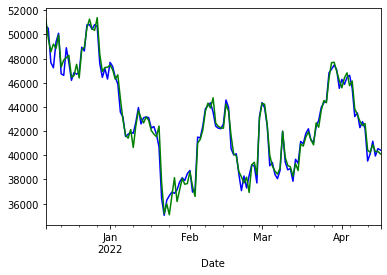

In [ ]:
compare_pred(predictions)

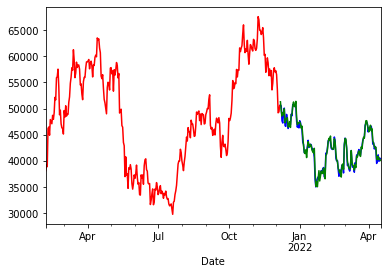

In [ ]:
plot_predictions(predictions)

In [ ]:
X_train.shape, Y_train.shape

((305, 6), (305, 1))

In [ ]:
X_test.shape, Y_test.shape

((131, 6), (131, 1))

In [133]:
# recurrent model

recurrent = Sequential()
#recurrent.add(InputLayer(6))
recurrent.add(GRU(64,input_shape=(6,1)))
recurrent.add(Dense(1, 'relu'))

recurrent.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_13 (GRU)                (None, 64)                12864     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [134]:
recurrent_c= ModelCheckpoint('recurrent/', save_best_only=True)
recurrent.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [135]:
recurrent.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, callbacks=[recurrent_c])

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 0.9136 - root_mean_squared_error: 0.9558 

10/10 [==============================] - 7s 565ms/step - loss: 0.9136 - root_mean_squared_error: 0.9558 - val_loss: 0.5573 - val_root_mean_squared_error: 0.7465
Epoch 2/40
10/10 [==============================] - 0s 10ms/step - loss: 0.7054 - root_mean_squared_error: 0.8399 - val_loss: 0.6129 - val_root_mean_squared_error: 0.7829
Epoch 3/40
10/10 [==============================] - 0s 10ms/step - loss: 0.6211 - root_mean_squared_error: 0.7881 - val_loss: 0.5983 - val_root_mean_squared_error: 0.7735
Epoch 4/40
 1/10 [==>...........................] - ETA: 0s - loss: 0.8503 - root_mean_squared_error: 0.9221

10/10 [==============================] - 5s 568ms/step - loss: 0.6038 - root_mean_squared_error: 0.7771 - val_loss: 0.5538 - val_root_mean_squared_error: 0.7442
Epoch 5/40
10/10 [==============================] - ETA: 0s - loss: 0.5771 - root_mean_squared_error: 0.7597

10/10 [==============================] - 4s 496ms/step - loss: 0.5771 - root_mean_squared_error: 0.7597 - val_loss: 0.5425 - val_root_mean_squared_error: 0.7365
Epoch 6/40
 7/10 [====================>.........] - ETA: 0s - loss: 0.5627 - root_mean_squared_error: 0.7501

10/10 [==============================] - 5s 554ms/step - loss: 0.5665 - root_mean_squared_error: 0.7526 - val_loss: 0.5412 - val_root_mean_squared_error: 0.7357
Epoch 7/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.5688 - root_mean_squared_error: 0.7542

10/10 [==============================] - 5s 506ms/step - loss: 0.5609 - root_mean_squared_error: 0.7490 - val_loss: 0.5410 - val_root_mean_squared_error: 0.7355
Epoch 8/40
 1/10 [==>...........................] - ETA: 0s - loss: 0.5317 - root_mean_squared_error: 0.7292

10/10 [==============================] - 5s 573ms/step - loss: 0.5580 - root_mean_squared_error: 0.7470 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 9/40
 1/10 [==>...........................] - ETA: 0s - loss: 0.6503 - root_mean_squared_error: 0.8064

10/10 [==============================] - 4s 487ms/step - loss: 0.5560 - root_mean_squared_error: 0.7457 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 10/40
10/10 [==============================] - 0s 10ms/step - loss: 0.5545 - root_mean_squared_error: 0.7446 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 11/40
10/10 [==============================] - ETA: 0s - loss: 0.5541 - root_mean_squared_error: 0.7444

10/10 [==============================] - 5s 506ms/step - loss: 0.5541 - root_mean_squared_error: 0.7444 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 12/40
10/10 [==============================] - 0s 8ms/step - loss: 0.5525 - root_mean_squared_error: 0.7433 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 13/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.5455 - root_mean_squared_error: 0.7386

10/10 [==============================] - 9s 1s/step - loss: 0.5525 - root_mean_squared_error: 0.7433 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 14/40
10/10 [==============================] - 0s 28ms/step - loss: 0.5531 - root_mean_squared_error: 0.7437 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 15/40
10/10 [==============================] - 0s 19ms/step - loss: 0.5541 - root_mean_squared_error: 0.7444 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 16/40
 6/10 [=================>............] - ETA: 0s - loss: 0.6258 - root_mean_squared_error: 0.7911

10/10 [==============================] - 7s 813ms/step - loss: 0.5544 - root_mean_squared_error: 0.7446 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 17/40
10/10 [==============================] - 0s 11ms/step - loss: 0.5519 - root_mean_squared_error: 0.7429 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 18/40
10/10 [==============================] - 0s 11ms/step - loss: 0.5510 - root_mean_squared_error: 0.7423 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 19/40
10/10 [==============================] - 0s 12ms/step - loss: 0.5511 - root_mean_squared_error: 0.7424 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 20/40
10/10 [==============================] - 0s 12ms/step - loss: 0.5507 - root_mean_squared_error: 0.7421 - val_loss: 0.5409 - val_root_mean_squared_error: 0.7355
Epoch 21/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.5434 - root_mean_squared_error: 0.7371

10/10 [==============================] - 5s 544ms/step - loss: 0.5507 - root_mean_squared_error: 0.7421 - val_loss: 0.5408 - val_root_mean_squared_error: 0.7354
Epoch 22/40
 1/10 [==>...........................] - ETA: 0s - loss: 0.3906 - root_mean_squared_error: 0.6250

10/10 [==============================] - 4s 487ms/step - loss: 0.5514 - root_mean_squared_error: 0.7426 - val_loss: 0.5405 - val_root_mean_squared_error: 0.7352
Epoch 23/40
10/10 [==============================] - 0s 10ms/step - loss: 0.5513 - root_mean_squared_error: 0.7425 - val_loss: 0.5406 - val_root_mean_squared_error: 0.7353
Epoch 24/40
10/10 [==============================] - 0s 9ms/step - loss: 0.5504 - root_mean_squared_error: 0.7419 - val_loss: 0.5407 - val_root_mean_squared_error: 0.7353
Epoch 25/40
10/10 [==============================] - 0s 11ms/step - loss: 0.5498 - root_mean_squared_error: 0.7415 - val_loss: 0.5406 - val_root_mean_squared_error: 0.7353
Epoch 26/40
10/10 [==============================] - 0s 12ms/step - loss: 0.5499 - root_mean_squared_error: 0.7416 - val_loss: 0.5406 - val_root_mean_squared_error: 0.7353
Epoch 27/40
10/10 [==============================] - 0s 12ms/step - loss: 0.5505 - root_mean_squared_error: 0.7419 - val_loss: 0.5406 - val_root_mean_sq

10/10 [==============================] - 4s 478ms/step - loss: 0.5495 - root_mean_squared_error: 0.7413 - val_loss: 0.5404 - val_root_mean_squared_error: 0.7351
Epoch 32/40
10/10 [==============================] - 0s 9ms/step - loss: 0.5495 - root_mean_squared_error: 0.7413 - val_loss: 0.5405 - val_root_mean_squared_error: 0.7352
Epoch 33/40
10/10 [==============================] - 0s 9ms/step - loss: 0.5499 - root_mean_squared_error: 0.7416 - val_loss: 0.5404 - val_root_mean_squared_error: 0.7351
Epoch 34/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.5443 - root_mean_squared_error: 0.7378

10/10 [==============================] - 8s 873ms/step - loss: 0.5490 - root_mean_squared_error: 0.7409 - val_loss: 0.5404 - val_root_mean_squared_error: 0.7351
Epoch 35/40
10/10 [==============================] - 0s 12ms/step - loss: 0.5499 - root_mean_squared_error: 0.7416 - val_loss: 0.5404 - val_root_mean_squared_error: 0.7351
Epoch 36/40
 1/10 [==>...........................] - ETA: 0s - loss: 0.5307 - root_mean_squared_error: 0.7285

10/10 [==============================] - 5s 506ms/step - loss: 0.5488 - root_mean_squared_error: 0.7408 - val_loss: 0.5403 - val_root_mean_squared_error: 0.7351
Epoch 37/40
10/10 [==============================] - 0s 12ms/step - loss: 0.5506 - root_mean_squared_error: 0.7420 - val_loss: 0.5405 - val_root_mean_squared_error: 0.7352
Epoch 38/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.5187 - root_mean_squared_error: 0.7202

10/10 [==============================] - 5s 601ms/step - loss: 0.5512 - root_mean_squared_error: 0.7424 - val_loss: 0.5403 - val_root_mean_squared_error: 0.7351
Epoch 39/40
10/10 [==============================] - 0s 11ms/step - loss: 0.5492 - root_mean_squared_error: 0.7411 - val_loss: 0.5403 - val_root_mean_squared_error: 0.7351
Epoch 40/40
10/10 [==============================] - 0s 12ms/step - loss: 0.5504 - root_mean_squared_error: 0.7419 - val_loss: 0.5403 - val_root_mean_squared_error: 0.7351


In [136]:
predictions = recurrent.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [146]:
def plot_predictionsg(predictions):
    #inverse scale the predictions
    predictions = targetScaler.inverse_transform(predictions)
    #predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]
    predictions = pd.DataFrame(predictions.reshape(-1).tolist(), index=test_df.index)[0]
    
    train_df['Close'].plot(color='red')
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')
    
def compare_predg(predictions):
    predictions = targetScaler.inverse_transform(predictions)
    #predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]

    predictions = pd.DataFrame(predictions.reshape(-1).tolist(), index=test_df.index)[0]
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')

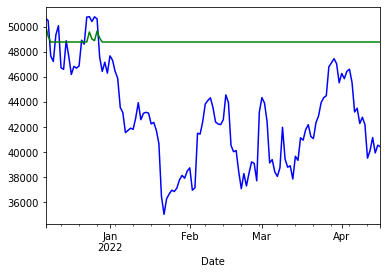

In [138]:
compare_predg(predictions)

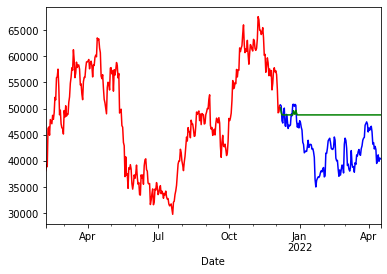

In [145]:
plot_predictions(predictions)

In [140]:
def calculate_r2(predictions, ground_truth):
    predictions = targetScaler.inverse_transform(predictions)
    score = r2_score(predictions, ground_truth)*100
    return score

In [147]:
# calculate R2 metrics

regressor_predictions = regressor.predict(X_test)
recurrent_predictions = recurrent.predict(X_test)

#recurrent_predictions = recurrent.predict(X_test)

regressor_r2 = calculate_r2(regressor_predictions, test_df['Close'])
recurrent_r2 = calculate_r2(recurrent_predictions, test_df['Close'])

#recurrent_r2 = calculate_r2(recurrent_predictions, test_df['Close'][WINDOW_SIZE:])


print(f'R2 for Linear Regression model -> {regressor_r2:.2f}%')
print(f'R2 for GRU model -> {recurrent_r2:.2f}%')



5/5 [==============================] - 0s 4ms/step
R2 for Linear Regression model -> 97.76%
R2 for GRU model -> -189430.37%
